# Exploratory Data Analysis

## Load Data

In [96]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm

In [97]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


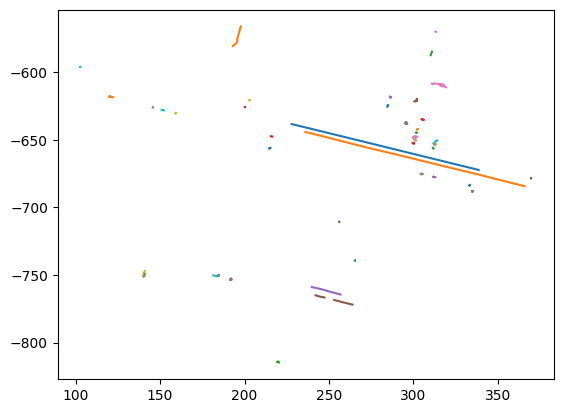

In [98]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

## Explore Data

In [99]:
object_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 
               'bus', 'static', 'background', 'construction', 
               'riderless_bicycle', 'unknown']

import os
if not os.path.exists('eda_plots'):
    os.makedirs('eda_plots')

In [100]:
# 1. Analyze zero vs. non-zero values
def analyze_zeros():
    print("\n=== Analyzing zero values ===")
    
    # Check overall zero percentage
    total_elements = train_data.size
    zero_elements = np.sum(train_data == 0)
    zero_percentage = (zero_elements / total_elements) * 100
    print(f"Overall zero percentage: {zero_percentage:.2f}%")
    
    # Check zero percentage for each feature
    feature_names = ['position_x', 'position_y', 'velocity_x', 'velocity_y', 'heading', 'object_type']
    for i, feature in enumerate(feature_names):
        zero_count = np.sum(train_data[:, :, :, i] == 0)
        feature_size = train_data[:, :, :, i].size
        print(f"{feature}: {(zero_count/feature_size)*100:.2f}% zeros")
    
    # Check if entire trajectories are zeros
    empty_agents = 0
    for scene_idx in range(train_data.shape[0]):
        for agent_idx in range(train_data.shape[1]):
            if np.all(train_data[scene_idx, agent_idx, :, 0:2] == 0):
                empty_agents += 1
    
    print(f"Empty agents (all positions are zero): {empty_agents} out of {train_data.shape[0]*train_data.shape[1]}")
    print(f"Percentage of empty agents: {(empty_agents/(train_data.shape[0]*train_data.shape[1]))*100:.2f}%")
    
    # Create a heatmap showing when agents are present (non-zero position)
    print("Generating presence heatmap...")
    # Sample a subset of scenes for visualization
    sample_size = min(100, train_data.shape[0])
    presence = np.zeros((sample_size, train_data.shape[2]))
    
    for i in range(sample_size):
        for t in range(train_data.shape[2]):
            # Count how many agents have non-zero positions at this timestep
            presence[i, t] = np.sum(~np.all(train_data[i, :, t, 0:2] == 0, axis=1))
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(presence, cmap='viridis')
    plt.title('Agent Presence Over Time (Non-zero positions)')
    plt.xlabel('Timestep')
    plt.ylabel('Scene Index')
    plt.savefig('eda_plots/agent_presence_heatmap.png')
    plt.close()

In [101]:

# 2. Analyze ego vehicle trajectory patterns
def analyze_ego_vehicle():
    print("\n=== Analyzing ego vehicle trajectories ===")
    
    # Extract ego vehicle data (agent index 0)
    ego_data = train_data[:, 0, :, :]
    
    # Plot displacement distribution
    displacements = []
    for i in range(ego_data.shape[0]):
        positions = ego_data[i, :, 0:2]
        # Find non-zero positions
        mask = ~np.all(positions == 0, axis=1)
        if np.sum(mask) > 1:
            valid_positions = positions[mask]
            displacement = np.linalg.norm(valid_positions[-1] - valid_positions[0])
            displacements.append(displacement)
    
    plt.figure(figsize=(10, 6))
    plt.hist(displacements, bins=30)
    plt.title('Ego Vehicle Total Displacement')
    plt.xlabel('Displacement (distance units)')
    plt.ylabel('Frequency')
    plt.savefig('eda_plots/ego_displacement_dist.png')
    plt.close()
    
    # Calculate and plot average speed
    speeds = []
    for i in range(ego_data.shape[0]):
        vx = ego_data[i, :, 2]  # velocity_x
        vy = ego_data[i, :, 3]  # velocity_y
        speed = np.sqrt(vx**2 + vy**2)
        # Filter out zeros
        speed = speed[speed > 0]
        if len(speed) > 0:
            speeds.append(np.mean(speed))
    
    plt.figure(figsize=(10, 6))
    plt.hist(speeds, bins=30)
    plt.title('Ego Vehicle Average Speed Distribution')
    plt.xlabel('Average Speed')
    plt.ylabel('Frequency')
    plt.savefig('eda_plots/ego_speed_dist.png')
    plt.close()



In [102]:

# 3. Analyze object types
def analyze_object_types():
    print("\n=== Analyzing object types ===")
    
    # Get object type distribution
    type_counts = {i: 0 for i in range(len(object_types))}
    total_agents = 0
    
    for scene_idx in range(train_data.shape[0]):
        for agent_idx in range(train_data.shape[1]):
            # Check if agent exists (has non-zero positions)
            if not np.all(train_data[scene_idx, agent_idx, :, 0:2] == 0):
                # Get most common object type for this agent
                obj_types = train_data[scene_idx, agent_idx, :, 5]
                obj_types = obj_types[obj_types > 0]
                if len(obj_types) > 0:
                    most_common_type = int(np.round(np.mean(obj_types)))
                    if most_common_type < len(object_types):
                        type_counts[most_common_type] += 1
                        total_agents += 1
    
    # Convert to percentages
    type_percentages = {object_types[k]: (v/total_agents)*100 for k, v in type_counts.items() if v > 0}
    
    plt.figure(figsize=(12, 6))
    plt.bar(type_percentages.keys(), type_percentages.values())
    plt.title('Distribution of Object Types')
    plt.xlabel('Object Type')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('eda_plots/object_type_distribution.png')
    plt.close()


In [103]:
# 4. Analyze trajectory patterns
def analyze_trajectory_patterns():
    print("\n=== Analyzing trajectory patterns ===")
    
    # Sample some trajectories for visualization
    num_samples = min(5, train_data.shape[0])
    
    for sample_idx in range(num_samples):
        scene = train_data[sample_idx]
        
        # Plot ego vehicle trajectory
        ego_traj = scene[0, :, 0:2]
        ego_mask = ~np.all(ego_traj == 0, axis=1)
        ego_traj = ego_traj[ego_mask]
        
        plt.figure(figsize=(10, 10))
        plt.plot(ego_traj[:, 0], ego_traj[:, 1], 'o-', color='tab:orange', label='Ego Vehicle', linewidth=3)
        
        # Plot other agents
        for agent_idx in range(1, min(10, scene.shape[0])):
            agent_traj = scene[agent_idx, :, 0:2]
            agent_mask = ~np.all(agent_traj == 0, axis=1)
            if np.sum(agent_mask) > 0:
                agent_traj = agent_traj[agent_mask]
                plt.plot(agent_traj[:, 0], agent_traj[:, 1], 'o-', alpha=0.7, label=f'Agent {agent_idx}')
        
        plt.title(f'Trajectory Visualization - Scene {sample_idx}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.legend()
        plt.axis('equal')
        plt.savefig(f'eda_plots/trajectory_scene_{sample_idx}.png')
        plt.close()
    
    # Create animation for one scene
    print("Creating trajectory animation...")
    make_gif(train_data[0], 'sample_trajectory')



In [104]:

# 5. Analyze prediction task split (train vs test)
def analyze_prediction_split():
    print("\n=== Analyzing prediction task split ===")
    
    # For the training data, compare the first 50 timesteps vs the next 60
    sample_idx = 0
    scene = train_data[sample_idx]
    
    # Ego vehicle trajectory
    ego_traj = scene[0, :, 0:2]
    
    # Split into input (first 50) and target (next 60)
    input_traj = ego_traj[:50]
    target_traj = ego_traj[50:]
    
    plt.figure(figsize=(10, 10))
    plt.plot(input_traj[:, 0], input_traj[:, 1], 'o-', color='blue', label='Input (50 timesteps)')
    plt.plot(target_traj[:, 0], target_traj[:, 1], 'o-', color='red', label='Target (60 timesteps)')
    plt.title('Input vs Target Trajectory Split')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.savefig('eda_plots/input_target_split.png')
    plt.close()
    
    # Calculate trajectory curvature for input vs target sections
    def calculate_curvature(trajectory):
        # Filter out zeros
        mask = ~np.all(trajectory == 0, axis=1)
        valid_traj = trajectory[mask]
        
        if len(valid_traj) < 3:
            return 0
        
        # Calculate displacement vectors
        disp_vectors = valid_traj[1:] - valid_traj[:-1]
        
        # Calculate angles between consecutive displacement vectors
        angles = []
        for i in range(len(disp_vectors) - 1):
            v1 = disp_vectors[i]
            v2 = disp_vectors[i+1]
            
            # Normalize vectors
            v1_norm = v1 / np.linalg.norm(v1)
            v2_norm = v2 / np.linalg.norm(v2)
            
            # Calculate angle
            dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
            angle = np.arccos(dot_product)
            angles.append(angle)
        
        return np.mean(angles) if angles else 0
    
    # Analyze curvature across multiple scenes
    input_curvatures = []
    target_curvatures = []
    
    for scene_idx in range(min(1000, train_data.shape[0])):
        ego_traj = train_data[scene_idx, 0, :, 0:2]
        input_traj = ego_traj[:50]
        target_traj = ego_traj[50:]
        
        input_curv = calculate_curvature(input_traj)
        target_curv = calculate_curvature(target_traj)
        
        if input_curv > 0 and target_curv > 0:
            input_curvatures.append(input_curv)
            target_curvatures.append(target_curv)
    
    # TODO: not exactly sure what this is representing
    
    plt.figure(figsize=(10, 6))
    plt.scatter(input_curvatures, target_curvatures, alpha=0.3)
    plt.plot([0, max(input_curvatures)], [0, max(input_curvatures)], 'r--')  # y=x line
    plt.title('Input vs Target Trajectory Curvature')
    plt.xlabel('Input Curvature (rad)')
    plt.ylabel('Target Curvature (rad)')
    plt.grid(True)
    plt.savefig('eda_plots/input_target_curvature.png')
    plt.close()



In [105]:
# 6. Analyze velocities and headings
def analyze_dynamics():
    print("\n=== Analyzing dynamics (velocity and heading) ===")
    
    # Extract ego vehicle data
    ego_data = train_data[:, 0, :, :]
    
    # Analyze velocity distributions
    vx = ego_data[:, :, 2].flatten()  # velocity_x
    vy = ego_data[:, :, 3].flatten()  # velocity_y
    
    # Filter out zeros
    vx = vx[vx != 0]
    vy = vy[vy != 0]
    
    # Calculate speed
    speed = np.sqrt(vx**2 + vy**2)
    
    # Plot velocity distributions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].hist(vx, bins=50)
    axs[0].set_title('X-Velocity Distribution')
    axs[0].set_xlabel('velocity_x')
    
    axs[1].hist(vy, bins=50)
    axs[1].set_title('Y-Velocity Distribution')
    axs[1].set_xlabel('velocity_y')
    
    axs[2].hist(speed, bins=50)
    axs[2].set_title('Speed Distribution')
    axs[2].set_xlabel('Speed')
    
    plt.tight_layout()
    plt.savefig('eda_plots/velocity_distributions.png')
    plt.close()
    
    # Analyze heading distribution
    heading = ego_data[:, :, 4].flatten()  # heading
    heading = heading[heading != 0]  # Filter out zeros
    
    # Convert from radians to degrees for easier interpretation
    heading_deg = np.degrees(heading) % 360
    
    plt.figure(figsize=(10, 6))
    plt.hist(heading_deg, bins=36)  # 10-degree bins
    plt.title('Heading Distribution (Degrees)')
    plt.xlabel('Heading (degrees)')
    plt.ylabel('Frequency')
    plt.savefig('eda_plots/heading_distribution.png')
    plt.close()
    
    # Create a polar histogram of headings
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')
    bins = np.linspace(0, 2*np.pi, 37)  # 36 bins of 10 degrees each
    hist, _ = np.histogram(heading, bins=bins)
    width = 2*np.pi / 36
    bars = ax.bar(bins[:-1], hist, width=width, alpha=0.5)
    ax.set_title('Polar Histogram of Headings')
    plt.savefig('eda_plots/heading_polar_histogram.png')
    plt.close()



In [106]:
# 7. Analyze correlations between features
def analyze_correlations():
    print("\n=== Analyzing feature correlations ===")
    
    # Sample some data for correlation analysis
    sample_size = min(1000, train_data.shape[0])
    
    # Create a dataframe with ego vehicle data
    features = []
    
    for scene_idx in range(sample_size):
        ego_data = train_data[scene_idx, 0, :, :]
        # Find non-zero positions
        mask = ~np.all(ego_data[:, 0:2] == 0, axis=1)
        if np.sum(mask) > 0:
            valid_data = ego_data[mask]
            for i in range(len(valid_data)):
                features.append({
                    'position_x': valid_data[i, 0],
                    'position_y': valid_data[i, 1],
                    'velocity_x': valid_data[i, 2],
                    'velocity_y': valid_data[i, 3],
                    'heading': valid_data[i, 4],
                    'speed': np.sqrt(valid_data[i, 2]**2 + valid_data[i, 3]**2)
                })
    
    df = pd.DataFrame(features)
    
    # Calculate correlation matrix
    corr = df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('eda_plots/feature_correlations.png')
    plt.close()
    
    # Check alignment of velocity and heading
    plt.figure(figsize=(10, 10))
    plt.scatter(df['heading'], np.arctan2(df['velocity_y'], df['velocity_x']), alpha=0.1)
    plt.plot([-np.pi, np.pi], [-np.pi, np.pi], 'r--')  # y=x line
    plt.title('Heading vs Velocity Direction')
    plt.xlabel('Heading (rad)')
    plt.ylabel('Velocity Direction (rad)')
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)
    plt.grid(True)
    plt.savefig('eda_plots/heading_vs_velocity_direction.png')
    plt.close()

# Function from the dataset description to visualize trajectories
def make_gif(data_matrix, name='example'):
   print(f"Creating animation for {name}...")
   cmap = plt.cm.get_cmap('viridis', 50)
   fig, ax = plt.subplots(figsize=(10, 10))
   
   # Function to update plot for each frame
   def update(frame):
       ax.clear()

       # Get data for current timestep
       for i in range(1, data_matrix.shape[0]):
           x = data_matrix[i, frame, 0]
           y = data_matrix[i, frame, 1]
           if x != 0 and y != 0:
               xs = data_matrix[i, :frame+1, 0]  # Include current frame
               ys = data_matrix[i, :frame+1, 1]  # Include current frame
               # trim all zeros
               mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
               xs = xs[mask]
               ys = ys[mask]

               # Only plot if we have points to plot
               if len(xs) > 0 and len(ys) > 0:
                   color = cmap(i)
                   ax.plot(xs, ys, alpha=0.9, color=color)
                   ax.scatter(x, y, s=80, color=color)

       ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
       ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1], s=80, color='tab:orange')
       # Set title with timestep
       ax.set_title(f'Timestep {frame}')
       # Set consistent axis limits
       ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
       ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
       ax.legend()

       return ax.collections + ax.lines

   # Create animation
   anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                               interval=100, blit=True)
   # Save as GIF
   anim.save(f'eda_plots/trajectory_visualization_{name}.gif', writer='pillow')
   plt.close()



In [107]:
# 8. Additional analysis for model development
def analyze_for_modeling():
    print("\n=== Analyzing data for modeling considerations ===")
    
    # Split data into input (first 50 timesteps) and target (next 60)
    # Calculate basic statistics for prediction difficulty assessment
    
    displacements = []
    avg_speeds = []
    directional_changes = []
    
    print("Analyzing prediction difficulty...")
    for scene_idx in tqdm(range(min(1000, train_data.shape[0]))):
        ego_traj = train_data[scene_idx, 0, :, :]
        
        # Split into input and target
        input_pos = ego_traj[:50, 0:2]
        target_pos = ego_traj[50:, 0:2]
        
        # Filter out zeros
        input_mask = ~np.all(input_pos == 0, axis=1)
        target_mask = ~np.all(target_pos == 0, axis=1)
        
        valid_input = input_pos[input_mask]
        valid_target = target_pos[target_mask]
        
        if len(valid_input) > 0 and len(valid_target) > 0:
            # Calculate displacement in target trajectory
            displacement = np.linalg.norm(valid_target[-1] - valid_target[0])
            displacements.append(displacement)
            
            # Calculate average speed in target
            speeds = []
            for i in range(len(valid_target) - 1):
                speed = np.linalg.norm(valid_target[i+1] - valid_target[i])
                speeds.append(speed)
            
            if speeds:
                avg_speeds.append(np.mean(speeds))
            
            # Calculate directional changes
            if len(valid_input) >= 2 and len(valid_target) >= 2:
                # Last direction in input
                input_last_dir = valid_input[-1] - valid_input[-2]
                input_last_dir = input_last_dir / np.linalg.norm(input_last_dir) if np.linalg.norm(input_last_dir) > 0 else input_last_dir
                
                # First direction in target
                target_first_dir = valid_target[1] - valid_target[0]
                target_first_dir = target_first_dir / np.linalg.norm(target_first_dir) if np.linalg.norm(target_first_dir) > 0 else target_first_dir
                
                # Calculate angle between directions
                dot_product = np.clip(np.dot(input_last_dir, target_first_dir), -1.0, 1.0)
                angle = np.arccos(dot_product)
                directional_changes.append(angle)
    
    # Plot distributions
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].hist(displacements, bins=30)
    axs[0].set_title('Target Trajectory Displacement')
    axs[0].set_xlabel('Displacement')
    
    axs[1].hist(avg_speeds, bins=30)
    axs[1].set_title('Target Average Speed')
    axs[1].set_xlabel('Average Speed')
    
    axs[2].hist(directional_changes, bins=30)
    axs[2].set_title('Input-Target Direction Change')
    axs[2].set_xlabel('Direction Change (rad)')
    
    plt.tight_layout()
    plt.savefig('eda_plots/modeling_considerations.png')
    plt.close()
    
    # Create a scatter plot of displacement vs direction change
    plt.figure(figsize=(10, 8))
    plt.scatter(displacements, directional_changes, alpha=0.3, c=avg_speeds, cmap='viridis')
    plt.colorbar(label='Average Speed')
    plt.title('Displacement vs Direction Change')
    plt.xlabel('Displacement')
    plt.ylabel('Direction Change (rad)')
    plt.grid(True)
    plt.savefig('eda_plots/displacement_vs_direction_change.png')
    plt.close()


In [108]:
# Run all analyses
def run_all_analyses():
    print("Starting comprehensive EDA...")
    analyze_zeros()
    analyze_ego_vehicle()
    analyze_object_types()
    analyze_trajectory_patterns()
    analyze_prediction_split()
    analyze_dynamics()
    analyze_correlations()
    analyze_for_modeling()
    print("\nEDA completed! All plots saved to 'eda_plots' directory.")

if __name__ == "__main__":
    run_all_analyses()

Starting comprehensive EDA...

=== Analyzing zero values ===
Overall zero percentage: 59.13%
position_x: 52.46% zeros
position_y: 52.46% zeros
velocity_x: 53.18% zeros
velocity_y: 53.18% zeros
heading: 52.46% zeros
object_type: 91.05% zeros
Empty agents (all positions are zero): 83062 out of 500000
Percentage of empty agents: 16.61%
Generating presence heatmap...

=== Analyzing ego vehicle trajectories ===

=== Analyzing object types ===

=== Analyzing trajectory patterns ===
Creating trajectory animation...
Creating animation for sample_trajectory...


/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_11379/537490143.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 50)



=== Analyzing prediction task split ===

=== Analyzing dynamics (velocity and heading) ===

=== Analyzing feature correlations ===

=== Analyzing data for modeling considerations ===
Analyzing prediction difficulty...


100%|██████████| 1000/1000 [00:00<00:00, 7579.09it/s]



EDA completed! All plots saved to 'eda_plots' directory.
